This script directly works on the new battery dataset (`3_clear`), the one with no ghosting effects. Here we load, save, preprocess it a little bit, and do some analysis. Then, we wrap it into dictionary and save it as a pickle file. Pickle files are nice because our SaxNerf library digests them really well. In fact, all you need to have is a well configured pickle file, and an ad-hoc configuration file inside the SaxNerf library. I'll definitely work in the morning because I'm a living dead or something. And that coffee was weird, I don't know.

Install libraries

In [ ]:
! pip install pillow imageio tifffile numpy matplotlib

Inspecting tif dataset

In [1]:
from PIL import Image
import os
from tqdm import tqdm

In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

tiff_path = "../data/battery/3_clear/LCO_abs.tif"

with tifffile.TiffFile(tiff_path) as tif:
    print(f"Number of pages in TIFF: {len(tif.pages)}") # Inspect the structure
    image_data = tif.asarray()                          # Read the image data as a numpy array
    

Number of pages in TIFF: 1


In [45]:
! tifffile --version  tiff.so

tifffile 2023.7.10


In [3]:
image_data.min(), image_data.max()

(-2.5599008, 1.5580326)

In [4]:
print(f"Extracted data shape: {image_data.shape}")

Extracted data shape: (1800, 2048, 2048)


Visualize one slice.

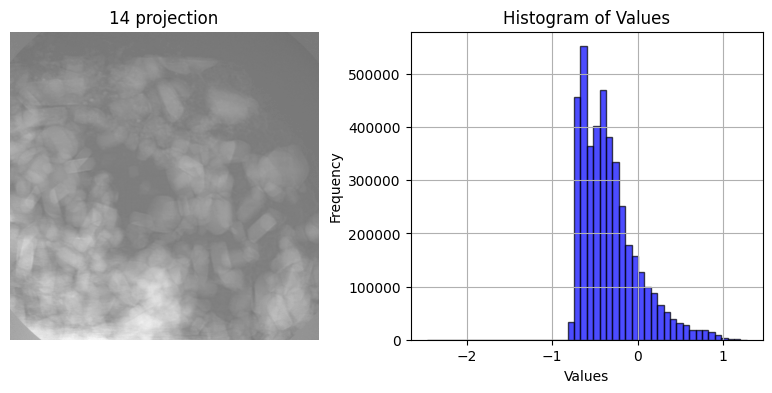

In [5]:
def show_image(image_data, id=14):
    id = id #np.random.randint(low=0, high=image_data.shape[0])
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    axes[0].imshow(image_data[id], cmap='gray')
    axes[0].set_title(f"{id} projection")
    axes[0].axis('off')

    axes[1].hist(image_data[id].flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[1].set_title("Histogram of Values")
    axes[1].set_xlabel("Values")
    axes[1].set_ylabel("Frequency")
    axes[1].grid(True)

    plt.show()

show_image(image_data)

In [ ]:
def show_images(dataset, num_images):
    """
    Displays a row of images from the dataset.

    Parameters:
        dataset (numpy array): The dataset of shape (N, H, W).
        num_images (int): Number of images to display.
    """
    selected_indices = np.linspace(0, len(dataset) - 1, num_images, dtype=int)  # Select images in order

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))  # Keep aspect ratio

    for ax, idx in zip(axes, selected_indices):
        ax.imshow(dataset[idx], cmap="gray", aspect='auto')
        ax.axis("off")
        ax.set_title(f"Image {idx}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage
show_images(resized_projections, num_images=5)

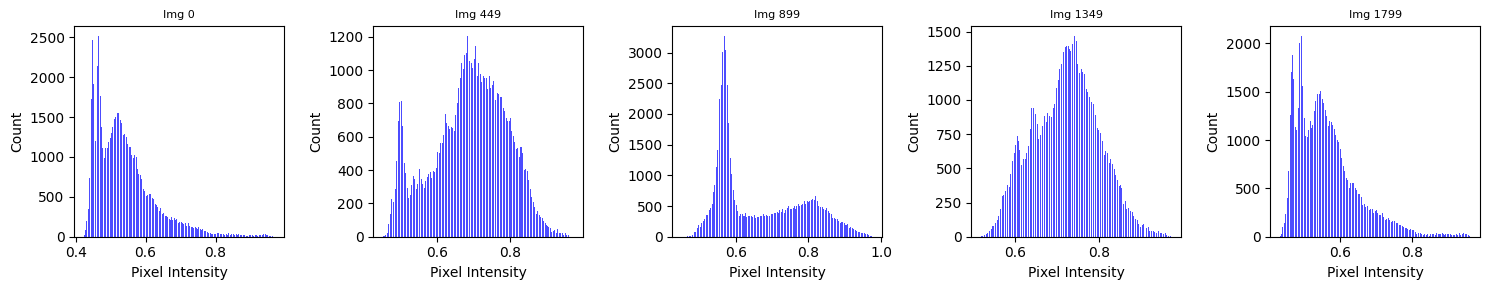

In [65]:
def show_histogram_row(dataset, num_images, bins):
    """
    Displays a row of histograms corresponding to selected images.

    Parameters:
        dataset (numpy array): The dataset of shape (N, H, W).
        num_images (int): Number of histograms to display.
        bins (int): Number of bins for the histogram.
    """
    selected_indices = np.linspace(0, len(dataset) - 1, num_images, dtype=int)  # Select images evenly

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))  # One row of histograms

    for ax, idx in zip(axes, selected_indices):
        ax.hist(dataset[idx].ravel(), bins=bins, color='blue', alpha=0.7)
        ax.set_title(f"Img {idx}", fontsize=8)
        ax.set_xlabel("Pixel Intensity")
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()

show_histogram_row(resized_projections, num_images=5, bins=198)

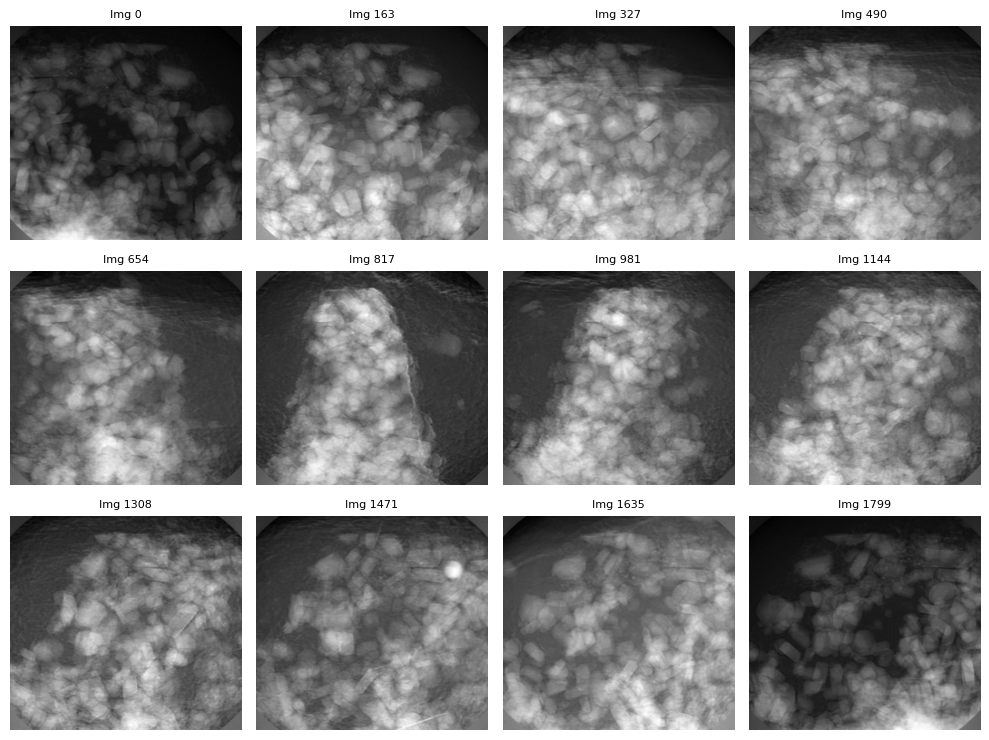

In [47]:
def show_image_grid(dataset, rows=2, cols=5):
    """
    Displays a grid of images from the dataset.

    Parameters:
        dataset (numpy array): The dataset of shape (N, H, W).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    total_images = rows * cols
    selected_indices = np.linspace(0, len(dataset) - 1, total_images, dtype=int)  # Select images evenly

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))  # Adjust size

    for ax, idx in zip(axes.ravel(), selected_indices):
        ax.imshow(dataset[idx], cmap="gray", aspect='auto')
        ax.axis("off")
        ax.set_title(f"Img {idx}", fontsize=8)

    plt.tight_layout()
    plt.show()

show_image_grid(resized_projections, rows=3, cols=4)

In [8]:
np.save('../data/battery/3_clear/projs.npy', image_data)

In [9]:
np.load('../data/battery/3_clear/projs.npy').shape

(1800, 2048, 2048)

Save to png only 180 among all the 1800 (too many and contain redundant info)

In [6]:
output_dir = "../data/z-bin/projs"

# Save every `step` slice
step = 1
selected_slices = range(0, len(image_data), step)
print(f"Saving {len(selected_slices)} slices...")

# Resize and save the selected slices
for i, slice_idx in enumerate(tqdm(selected_slices)):
    slice = image_data[slice_idx]
    
    # Normalize (0-255) and convert to uint8
    normalized_slice = ((slice - slice.min()) / (slice.max() - slice.min()) * 255).astype(np.uint8)
    
    # Resize the slice to 256x256
    resized_slice = Image.fromarray(normalized_slice).resize((256, 256), Image.BICUBIC)
    
    # Save the resized slice as a PNG file
    slice_path = os.path.join(output_dir, f"slice_{i:03d}.png")
    resized_slice.save(slice_path)

print(f"Saved {len(selected_slices)} resized slices to '{output_dir}'")

Saving 180 slices...


  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:07<00:00, 25.42it/s]

Saved 180 resized slices to '../data/battery/3_clear/png'


Create gif

In [7]:
from PIL import Image
import os

def create_gif_from_folder(folder_path, output_filename, duration=100):
    # Get all PNG files from the folder and sort them
    images = sorted([img for img in os.listdir(folder_path) if img.endswith(".png")])
    
    # Load images into a list
    frames = [Image.open(os.path.join(folder_path, img)) for img in images]

    # Save the frames as a GIF
    frames[0].save(
        output_filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,  # Duration between frames in milliseconds
        loop=0              # Loop forever
    )

# Example usage
create_gif_from_folder("../data/battery/3_clear/png", "../data/battery/3_clear/png/anim.gif", duration=150)

Inspect raw data

In [6]:
image_data.shape

(1800, 2048, 2048)

In [11]:
def plot_statistics(projections, title):
    num_images = projections.shape[0]
    x_values = np.arange(1, num_images+1)
    min_values = []
    max_values = []
    mean_values = []

    for i in range(num_images):
        min_values.append(np.min(projections[i]))
        max_values.append(np.max(projections[i]))
        mean_values.append(np.mean(projections[i]))

    plt.figure(figsize=[8, 4])
    plt.plot(x_values, min_values, label='min')
    plt.plot(x_values, max_values, label='max')
    plt.plot(x_values, mean_values, label='mean')
    plt.title(f'max/min/mean values across {title}')
    plt.legend()
    plt.grid()
    plt.show()

#plot_statistics(image_data, 'raw images')

Now we can either:
- pick one every 180 projections, or
- averaging every 10 projections

In both cases we have 180 total projections. Then we resize to 256x256 and regularize in a predefined range.

In [7]:
# pick one every 180 projections, or just all of them, why not
projections = image_data#[::10]
projections.shape

(1800, 2048, 2048)

Resize images to 256x256 and adjust in predefined range.

In [8]:
resized_projections = []
target_size = (256, 256)
min_thresh = 0.0
max_thresh = 1.0

for i in tqdm(range(projections.shape[0])):

    # Convert each slice to uint8 format (0-255) for resizing
    slice_normalized = ((projections[i] - projections[i].min()) / (projections[i].max() - projections[i].min()) * 255).astype(np.uint8)
    
    # Convert slice to PIL image, resize, and back to numpy array
    resized_slice = Image.fromarray(slice_normalized).resize(target_size, Image.BICUBIC)
    resized_slice = np.array(resized_slice, dtype=np.float32)

    # Rescale to the specified range
    resized_slice = resized_slice / 255.0  # Normalize to 0-1
    resized_slice = resized_slice * (max_thresh - min_thresh) + min_thresh  # Scale to [min_thresh, max_thresh]
    
    resized_projections.append(np.array(resized_slice))

# Stack the resized slices back into a single numpy array
resized_projections = np.stack(resized_projections, axis=0)
resized_projections.shape

  0%|          | 0/1800 [00:00<?, ?it/s]

100%|██████████| 1800/1800 [00:48<00:00, 37.19it/s]


(1800, 256, 256)

Here we plot the histogram of the distribuion of the resized projections (size 1800x256x256)

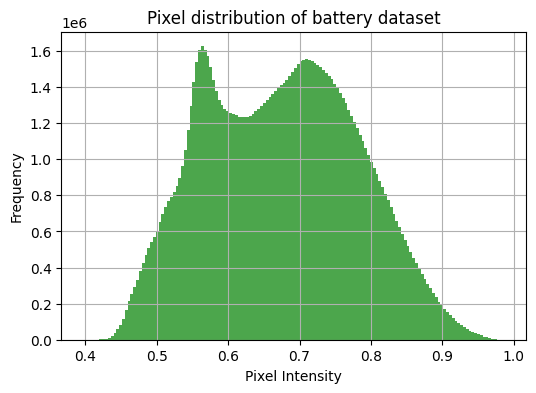

In [43]:
def plot_distribution(dataset):
    # Flatten the dataset to get all pixel values
    pixel_values = dataset.flatten()

    # Plot the histogram
    plt.figure(figsize=(6, 4))
    plt.hist(pixel_values, bins=150, color="green", alpha=0.7)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Pixel distribution of battery dataset")
    plt.grid(True)

    # Show the plot
    plt.show()

plot_distribution(resized_projections)

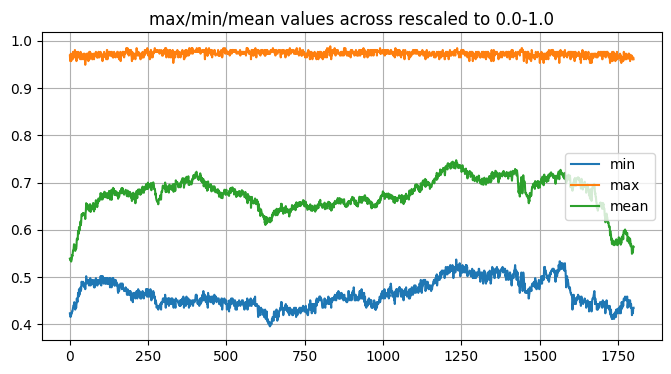

In [12]:
plot_statistics(resized_projections, f'rescaled to {min_thresh}-{max_thresh}')

Averaging. We define the overlapping averaging process based on different window sizes. We also keep the final number of projections fixed.

In [24]:
# average every 10 projections
reshaped_projections = resized_projections.reshape(60, 30, 256, 256)
projections = reshaped_projections.mean(axis=1)
projections.shape

(60, 256, 256)

In [25]:
final_projections = projections
final_projections.shape

(60, 256, 256)

In [19]:
# here we need to get the angles in randiants
num_train = 180
angles = np.linspace(0, np.pi, num_train, endpoint=False)

# Print the angles array
print(angles)

[0.         0.01745329 0.03490659 0.05235988 0.06981317 0.08726646
 0.10471976 0.12217305 0.13962634 0.15707963 0.17453293 0.19198622
 0.20943951 0.2268928  0.2443461  0.26179939 0.27925268 0.29670597
 0.31415927 0.33161256 0.34906585 0.36651914 0.38397244 0.40142573
 0.41887902 0.43633231 0.45378561 0.4712389  0.48869219 0.50614548
 0.52359878 0.54105207 0.55850536 0.57595865 0.59341195 0.61086524
 0.62831853 0.64577182 0.66322512 0.68067841 0.6981317  0.71558499
 0.73303829 0.75049158 0.76794487 0.78539816 0.80285146 0.82030475
 0.83775804 0.85521133 0.87266463 0.89011792 0.90757121 0.9250245
 0.9424778  0.95993109 0.97738438 0.99483767 1.01229097 1.02974426
 1.04719755 1.06465084 1.08210414 1.09955743 1.11701072 1.13446401
 1.15191731 1.1693706  1.18682389 1.20427718 1.22173048 1.23918377
 1.25663706 1.27409035 1.29154365 1.30899694 1.32645023 1.34390352
 1.36135682 1.37881011 1.3962634  1.41371669 1.43116999 1.44862328
 1.46607657 1.48352986 1.50098316 1.51843645 1.53588974 1.55334

In [9]:
def average_projections(projections, window_size):
    """
    Averages projections using overlapping windows.

    :param projections: NumPy array of shape (1800, 256, 256)
    :param window_size: The number of projections to average in each window
    :return: Averaged projections (180, 256, 256)
    """
    num_projections = projections.shape[0]  # 1800 projections
    step_size = num_projections // 180  # Step size to ensure 180 final projections
    
    padded_projections = np.concatenate([projections, projections[:window_size-step_size]], axis=0)
    averaged_projections = []
    
    for i in range(0, num_projections, step_size):
        avg_projection = np.mean(padded_projections[i:i + window_size], axis=0)
        averaged_projections.append(avg_projection)
    
    return np.array(averaged_projections)

# Try different averaging window sizes
window_sizes = [20, 30, 40, 50, 60]
averaged_results = {w: average_projections(resized_projections, w) for w in window_sizes}

# Check the shapes of the averaged projections
for w, avg_proj in averaged_results.items():
    print(f"Window size {w}: {avg_proj.shape}")  # Should be (180, 256, 256)

Window size 20: (180, 256, 256)
Window size 30: (180, 256, 256)
Window size 40: (180, 256, 256)
Window size 50: (180, 256, 256)
Window size 60: (180, 256, 256)


In [32]:
final_projections = averaged_results[60]
final_projections.shape

(180, 256, 256)

In [57]:
output_dir = "../data/z-bin/projs/60"
projs_to_save = averaged_results[60]

# Save every `step` slice
step = 1
selected_projs = range(0, len(projs_to_save), step)
print(f"Saving {len(selected_projs)} projections...")

# Resize and save the selected slices
for i, proj_idx in enumerate(tqdm(selected_projs)):
    proj = projs_to_save[proj_idx]
    
    # Normalize (0-255) and convert to uint8
    normalized_proj = ((proj - proj.min()) / (proj.max() - proj.min()) * 255).astype(np.uint8)
    
    # Convert to Image
    image_proj = Image.fromarray(normalized_proj)

    # Save the resized slice as a PNG file
    proj_path = os.path.join(output_dir, f"proj_{i:03d}.png")
    image_proj.save(proj_path)

print(f"Saved {len(selected_projs)} resized slices to '{output_dir}'")

Saving 180 projections...


100%|██████████| 180/180 [00:02<00:00, 84.63it/s]

Saved 180 resized slices to '../data/z-bin/projs/60'


A) Given all 1800 projections, the below snippet allows you to restrict angle range and calibrate the number of projections to draw in such range.

In [26]:
resized_projections.shape

(1800, 256, 256)

In [13]:
start_angle = 0                        # start of restricted range in degrees
end_angle = 179                        # end of restricterd range in degrees
total_angle = end_angle - start_angle
step_angle = 0.1                        # angle step interval (original)
num_train = 360                          # desired number of projections
#desired_step = 1.5                     # desired angular interval

print('Total angle:', total_angle, 'degrees')
print()

# compute indices for restricted angle range
start_index = int(start_angle / step_angle)     # initial index
end_index = int(end_angle / step_angle)         # final index

# A)select indices at fixed step interval
#total_indices = np.linspace(start_index, end_index, num_train, dtype=int)
#final_projections = resized_projections[total_indices]

# B) Generate random indices within the range
total_indices = np.random.choice(np.arange(start_index, end_index + 1), num_train, replace=False)

# Sort indices to keep the order (optional)
total_indices.sort()

# Select random projections
final_projections = resized_projections[total_indices]

Total angle: 179 degrees



In [15]:
# print selected indices
print(len(total_indices), "indices were selected.")
print()
print(f"{len(final_projections)} projections were selected in {start_angle}-{end_angle} degrees")

360 indices were selected.

360 projections were selected in 0-179 degrees


In [17]:
# A) Generate angles array - FIXED
# angles = np.linspace(np.deg2rad(start_angle), np.deg2rad(end_angle), num_train)

# B) Angles
angles = np.radians(total_indices * step_angle)

# Print the angles
print()
print("Number of angles:", len(angles))
print(f"From {angles[0]} to {angles[-1]:.3f} rad.")


Number of angles: 360
From 0.033161255787892266 to 3.110 rad.


B) Old way to select angle ranges.

In [70]:
# Acquisition angles
total_angle = 180.0
num_train = 180
start_angle = 0.0
print(f'{num_train} projections selected!')
print(f'Selected range angle: {start_angle}-{total_angle+start_angle}, Total: {total_angle}')

180 projections selected!
Selected range angle: 0.0-180.0, Total: 180.0


In [64]:
# Generate angles with fixed intervals
angles = np.linspace(0, total_angle / 180 * np.pi, num_train+1)[:-1] + start_angle/ 180 * np.pi
print(angles.shape)

# Pick projections according to angles
start_proj = 60
end_proj = 120

final_projections = resized_projections[start_proj:end_proj]#[::2]
final_projections.shape

(60,)


(60, 256, 256)

In [65]:
angles/np.pi * 180

array([ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
        71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
        82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119.])

In [17]:
# Generate angles with random intervals

# Step 1: Generate `num_train` unique random indices between 0 and 179 (representing angles in degrees)
random_indices = np.random.choice(180, size=num_train, replace=False)  # No duplicates
random_indices.sort()

# Step 2: Select the corresponding projections
final_projections = resized_projections[random_indices]

# Step 3: Convert the selected indices (angles in degrees) to radians
angles = random_indices * (np.pi / 180)

print(f'final_projections: {final_projections.shape}')
print(f'angles: {angles.shape}')

final_projections: (90, 256, 256)
angles: (90,)


In [18]:
final_projections.shape

(360, 256, 256)

In [19]:
print(np.min(final_projections))
print(np.max(final_projections))

0.39607844
0.9843137


This is the npz saving part.

In [15]:
file_path = "../data/battery/3_clear/npz/projs_angles_50_random_projs.npz"
np.savez(file_path, projs=final_projections, angles=angles)

print(f"NPZ saved in {file_path}.")

NPZ saved in ../data/battery/3_clear/npz/projs_angles_50_random_projs.npz.


This is the npz reading part.

In [47]:
import numpy as np

name_projs_angles = 'projs_angles_70_random_projs'
data = np.load(f'../data/battery/3_clear/npz/range_0_1/{name_projs_angles}.npz')
for key in data.keys():
    print(f"{key}: {data[key].shape}")
print()

print('original data range:')
print(np.min(data['projs']))
print(np.max(data['projs']))
print()

def rescale_array(array, new_min, new_max):
    old_min, old_max = array.min(), array.max()
    return (array - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

resized_projections = rescale_array(data['projs'], new_min=0, new_max=0.07)
print('new data range:')
print(np.min(resized_projections))
print(np.max(resized_projections))

# some plotting
'''
plot_statistics(resized_projections, 'rescaled images')

id_random_proj = np.random.randint(180)
plt.imshow(resized_projections[id_random_proj], cmap="gray")
plt.title(f"{id_random_proj} Projection")
plt.show()
'''

'''
dict_npz = {
    'projs': rescaled_array,
    'angles': data['angles']
}
'''

# saving projs and angles to npz
file_path = f"../data/battery/3_clear/npz/range_0_007/{name_projs_angles}.npz"
np.savez(file_path, projs=resized_projections, angles=data['angles'])

print(f"NPZ saved in {file_path}.")

# storing train data
final_projections = resized_projections
angles = data['angles']

projs: (180, 256, 256)
angles: (70,)

original data range:
0.4
0.9843137

new data range:
0.0
0.07
NPZ saved in ../data/battery/3_clear/npz/range_0_007/projs_angles_70_random_projs.npz.


This is the pickle saving part. In theory you should have the 3D CT volume (precomputed e.g. with SART) and use it as ground truth. You assign such volume to the `image` attribute in the `picke_dict` dictionary.

In [20]:
gt_volume = np.zeros((256, 256, 256))
#gt_volume = np.load("data/npy/no_ghost/SART_1_180.npy")

This is the pickle constructor for SaxNerf

In [21]:
import pickle

pickle_dict = {
    "numTrain": 360,                # my train projections
    "numVal": 360,                  # we test on the same train projections
    "DSD": 1500.0,
    "DSO": 1000.0,
    "nDetector": [256, 256],        # image size
    "dDetector": [1.0, 1.0],        # pixel size
    "nVoxel": [256, 256, 256],
    "dVoxel": [1.0, 1.0, 1.0],    
    "offOrigin": [0, 0, 0],
    "offDetector": [0, 0],
    "accuracy": 0.5,
    "mode": "parallel",
    "filter": None,
    "totalAngle": total_angle,
    "startAngle": start_angle,
    "randomAngle": False,
    "convert": True,
    "rescale_slope": 1.0,
    "rescale_intercept": 0.0,
    "normalize": True,
    "noise": 0,
    "image": gt_volume,                # GT volume, if any
    "train": {
        "angles": angles,
        "projections": final_projections
    },
    "val": {
        "angles": angles,
        "projections": final_projections
    }
}

file_path = "../data/z-bin/shuffle/id_35.pickle"
with open(file_path, 'wb') as file:
    pickle.dump(pickle_dict, file)

print(f"{file_path} saved!")

../data/z-bin/shuffle/id_35.pickle saved!


This is the pickle file to be fed to R2Gaussian.

In [36]:
# in case you didn't define earlier
total_angle = 180
start_angle = 0
print(f"final projections: {final_projections.shape}")
print(f'{len(angles)} angles from {angles[0]} to {angles[-1]}')

final projections: (180, 256, 256)
180 angles from 0.0 to 3.12413936106985


In [37]:
import pickle

pickle_dict = {
    "mode": "parallel",
    "DSD": 1500.0,
    "DSO": 1000.0,
    "nDetector": [256, 256],        # image size
    "sDetector": [256, 256],
    "nVoxel": [256, 256, 256],
    "sVoxel": [256, 256, 256],
    "offOrigin": [0, 0, 0],
    "offDetector": [0, 0],
    "accuracy": 0.5,
    "totalAngle": total_angle,
    "startAngle": start_angle,
    "noise": True,
    "filter": None,
    "numTrain": num_train,                  # my train projections
    "numVal": num_train,                    # we test on the same train projections
    "dDetector": [1.0, 1.0],                # pixel size
    "dVoxel": [1.0, 1.0, 1.0],    
    "train": {
        "angles": angles,
        "projections": final_projections
    },
    "val": {
        "angles": angles,
        "projections": final_projections
    },
    "image": gt_volume,                # GT volume, if any
}

'''
"randomAngle": False,
"convert": True,
"rescale_slope": 1.0,
"rescale_intercept": 0.0,
"normalize": True,
'''

file_path = "../data/z-bin/shuffle/id_34.pickle"
with open(file_path, 'wb') as file:
    pickle.dump(pickle_dict, file)

print(f"{file_path} saved!")

../data/z-bin/shuffle/id_34.pickle saved!


In [34]:
print('total angle:', total_angle)
print('start angle:', start_angle)
print('num train:', num_train)
print('shape of final projections:', final_projections.shape)

total angle: 180
start angle: 0
num train: 60
shape of final projections: (60, 256, 256)


In [35]:
angles[0], 'to', angles[-1]

(0.0, 'to', 3.089232776029963)

In [36]:
len(angles)

60